In [8]:
#General Import and Naming

File_Name = 'ANN_COSMO'
File_Dataset = "Dataset_CMCCPP_Sand8_or.xlsx"
File_Surfactant = 'Surfactant.xlsx'
File_Solid  = 'Solid.xlsx'
attr = ''

seed = 24

# Python â‰¥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn â‰¥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow â‰¥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"


# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(seed)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann " + File_Name
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [9]:
#Name Selection
Desc_Config = ['Xeq(mg/L)', 'Temperature_(C)', 'pH_Alkalinity', 'Salinity_Monovalent(%wt)' ]
Desc_Target = ['Sum of Yads(mg/g)']
Desc_Solid =  ['PZC','Size(micro_meter)', 'Area(m^2/g)']

#Load dataset
df = pd.read_excel(File_Dataset)

# Select df range
Dataset_General_CMCCPP = Desc_Config + ['PZC','Area(m^2/g)' ] + ['Transitional', 'Degree_of_Branching', 'Surf_Length' ] + ['R','Critical Micelle Concentration (M)'] + Desc_Target
Dataset_COSMO_CMCCPP = Desc_Config + ['PZC','Area(m^2/g)' ] + ['NHB-HB_Donor'] + ['Head_NHB-Hydrophobicity', 'Head_NHB-HB_Acceptor', 'Head_OT-HB_Acceptor'] + ['Tail_NHB-Hydrophobicity'] + ['R', 'Critical Micelle Concentration (M)'] + Desc_Target
Dataset_COSMO_CMCCPP_LV = Desc_Config + ['PZC','Area(m^2/g)' ] + ['NHB-HB_Donor'] + ['Head_NHB-Hydrophobicity', 'Head_NHB-HB_Acceptor', 'Head_OT-HB_Acceptor'] + ['Tail_NHB-Hydrophobicity'] + ['MolVol','Length (Avogadro, A)','Critical Micelle Concentration (M)']+ Desc_Target
Dataset_COSMO = Desc_Config + ['PZC','Area(m^2/g)' ] + ['NHB-HB_Donor'] + ['Head_NHB-Hydrophobicity', 'Head_NHB-HB_Acceptor', 'Head_OT-HB_Acceptor'] + ['Tail_NHB-Hydrophobicity'] + Desc_Target
Dataset_COSMO_LV = Desc_Config + ['PZC','Area(m^2/g)' ] + ['NHB-HB_Donor'] + ['Head_NHB-Hydrophobicity', 'Head_NHB-HB_Acceptor', 'Head_OT-HB_Acceptor'] + ['Tail_NHB-Hydrophobicity'] + ['MolVol','Length (Avogadro, A)']+ Desc_Target

df = df[Dataset_COSMO_LV]
Descriptor_NonX = list(df.columns.values)
Descriptor_NonX.remove('Sum of Yads(mg/g)')
Descriptor_NonX.remove('Xeq(mg/L)' )


In [10]:
#Split Dataset

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.20, random_state=seed)

test_set.head()
train_set.head()

X_test_X = test_set[['Xeq(mg/L)']].copy()
X_test_NonX = test_set[Descriptor_NonX].copy() 
X_test = pd.concat([X_test_X, X_test_NonX], axis=1).copy()
y_test = test_set[['Sum of Yads(mg/g)']].copy()

X_train_X = train_set[['Xeq(mg/L)']].copy()
X_train_NonX = train_set[Descriptor_NonX].copy() 
X_train = pd.concat([X_train_X, X_train_NonX], axis=1).copy()
y_train = train_set[['Sum of Yads(mg/g)']].copy()

In [11]:
#Subclass API Langmuir Layer

class LangmuirLayer(tf.keras.layers.Layer):
    def __init__(self, k, name=None, **kwargs):
        super(LangmuirLayer, self).__init__(name=name)
        self.k = k
        super(LangmuirLayer, self).__init__(**kwargs)
  # def build (self, inputs): no need as no constant introduced
    def get_config(self):
        config = super(LangmuirLayer, self).get_config()
        config.update({"k": self.k})
        return config
    def call(self, inputs):
        self.Ce = inputs[:, 0]
        self.Kl = inputs[:, 1]
        self.qm  = inputs[:, 2]        
        self.qm_mult_kl = tf.math.multiply(self.qm, self.Kl)
        self.kl_mult_ce = tf.math.multiply(self.Kl, self.Ce)
        self.below = tf.math.add(1.0, self.kl_mult_ce)
        self.right = tf.math.divide(self.Ce, self.below)
        self.qe = tf.math.multiply(self.qm_mult_kl, self.right)
        return tf.transpose(self.qe)

In [33]:
#Generate Model
#Forloops to seach optimum config


#Model
from unicodedata import name


tf.keras.backend.clear_session()
tf.random.set_seed(seed)

input_X     = keras.layers.Input(shape=X_train_X.shape[1], name='eqconcx_input')
input_NonX  = keras.layers.Input(shape=X_train_NonX.shape[1], name='othervar_input')
Batch_Norm1 = keras.layers.BatchNormalization()(input_NonX)
hidden1     = keras.layers.Dense(8, activation="relu")(Batch_Norm1)
Batch_Norm2 = keras.layers.BatchNormalization()(hidden1)
hidden2     = keras.layers.Dense(4, activation="gelu")(Batch_Norm2)
hidden3     = keras.layers.Dense(2, activation="exponential",  name="Adsorption_output")(hidden2)
concat      = keras.layers.concatenate([input_X, hidden3])
langmuir_layer = LangmuirLayer(1, name='langmuir_layer')(inputs=concat)
model       = keras.models.Model(inputs=[input_X, input_NonX], outputs=[langmuir_layer])

model.summary()
keras.utils.plot_model(model, "Structure " +File_Name + attr + ".png", show_shapes=True)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005, decay=5e-4),
              loss='mean_squared_error',
              metrics=[keras.metrics.MeanAbsoluteError(name='mean_absolute_error')]
              )

#Integrate TensorBoard [OK]
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime(File_Name + attr + " run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_dir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_dir)

#Train Model
history = model.fit([X_train_X, X_train_NonX], [y_train], epochs=1000,
                    validation_data=([X_test_X, X_test_NonX], [y_test]), callbacks=[tensorboard_cb])




Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
othervar_input (InputLayer)     [(None, 12)]         0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 12)           48          othervar_input[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 8)            104         batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 8)            32          dense[0][0]                      
______________________________________________________________________________________________

In [12]:
# Save Model & Show Result
model.save(File_Name+attr, save_traces=True)
        
#Analyze Result
#RSME
from sklearn.metrics import mean_squared_error
pred_train = model.predict([X_train_X, X_train_NonX])
train_RSME = np.sqrt(mean_squared_error(y_train,pred_train))
print('train RSME:{0}'  .format(train_RSME))
pred = model.predict([X_test_X, X_test_NonX])
test_RSME = np.sqrt(mean_squared_error(y_test,pred))
print('test RSME:{0}'.format(test_RSME))

#Rsquare
from sklearn.metrics import r2_score
Train_Rsquare = r2_score(y_train, pred_train)
print ('Train Rsquare:{0}'.format(Train_Rsquare))
Test_RSquare = r2_score(y_test, pred)
print ('Test RSquare:{0}'.format(Test_RSquare))

#Plot Train 
a = plt.axes(aspect='equal')
plt.scatter(y_train, pred_train, alpha=0.3)
plt.xlabel('Experiment Value (mg/g)')
plt.ylabel('Predicted Value (mg/g)')
plt.title('Train Plot')
plt.text(0.02,0.01, '$r^2$: {0:1.2f} -  RSME:{1:1.2f}'.format(Train_Rsquare, train_RSME) )
plt.xscale('log')
plt.yscale('log')
save_fig('Train Scatter'+' #' +File_Name + attr)
plt.show()

#Train Error <<<<<<<<<<<<<<<<<<<<<<<<<<
error_train = pred_train - y_train['Sum of Yads(mg/g)']
plt.hist(error_train, bins=25)
plt.xlabel('Prediction Error Absolute (mg/g)')
plt.ylabel('Count')
plt.title('Train Error Distribution')
save_fig('Train Var' +' #' +File_Name + attr)
plt.show()

#Plot Test
a = plt.axes(aspect='equal')
plt.scatter(y_test, pred, alpha=0.3)
plt.xlabel('Experiment Value (mg/g)')
plt.ylabel('Predicted Value (mg/g)')
plt.title('Test Plot')
plt.text(0.02,0.01, '$r^2$: {0:1.2f} -  RSME:{1:1.2f}'.format(Test_RSquare, test_RSME) )
plt.xscale('log')
plt.yscale('log')
save_fig('Test Scatter'+' #' +File_Name + attr)
plt.show()

#Test Error
error_test = pred - y_test['Sum of Yads(mg/g)']
plt.hist(error_test, bins=25)
plt.xlabel('Prediction Error Absolute (mg/g)')
plt.ylabel('Count')
plt.title('Test Error Distribution')
save_fig('Test Var'+' #' +File_Name + attr)
plt.show()      



NameError: name 'model' is not defined

train RSME load:0.22309087232400698
test RSME load:0.5613596896966657
Train Rsquare load:0.9469209929258391
Test RSquare load:0.8716269626654279
Saving figure Check Train Scatter #ANN_COSMO


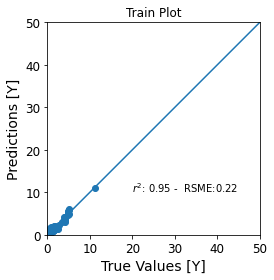

Saving figure Check Test Scatter #ANN_COSMO


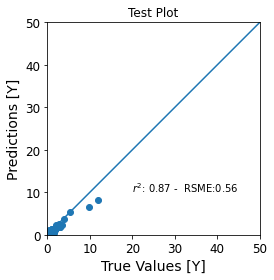

In [13]:
#Load Model ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
tf.keras.backend.clear_session()
tf.random.set_seed(seed)


#Load Model
#File_Name = {fill if different}
model = tf.keras.models.load_model(File_Name+attr, custom_objects={'LangmuirLayer': LangmuirLayer})


#RSME
from sklearn.metrics import mean_squared_error
pred_train = model.predict([X_train_X, X_train_NonX])
train_RSME = np.sqrt(mean_squared_error(y_train,pred_train))
print('train RSME load:{0}'  .format(train_RSME))
pred = model.predict([X_test_X, X_test_NonX])
test_RSME = np.sqrt(mean_squared_error(y_test,pred))
print('test RSME load:{0}'.format(test_RSME))

#Rsquare
from sklearn.metrics import r2_score
Train_Rsquare = r2_score(y_train, pred_train)
print ('Train Rsquare load:{0}'.format(Train_Rsquare))
Test_RSquare = r2_score(y_test, pred)
print ('Test RSquare load:{0}'.format(Test_RSquare))

#Plot Train 
a = plt.axes(aspect='equal')
plt.scatter(y_train, pred_train)
plt.xlabel('True Values [Y]')
plt.ylabel('Predictions [Y]')
plt.title('Train Plot')
plt.text(20,10, '$r^2$: {0:1.2f} -  RSME:{1:1.2f}'.format(Train_Rsquare, train_RSME) )
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
save_fig('Check Train Scatter'+' #' +File_Name + attr)
plt.show()

#Plot Test
a = plt.axes(aspect='equal')
plt.scatter(y_test, pred)
plt.xlabel('True Values [Y]')
plt.ylabel('Predictions [Y]')
plt.title('Test Plot')
plt.text(20,10, '$r^2$: {0:1.2f} -  RSME:{1:1.2f}'.format(Test_RSquare, test_RSME) )
lims = [0,50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
save_fig('Check Test Scatter'+' #' +File_Name + attr)
plt.show()


In [14]:
# Create Input Var ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
size = 100000
fold = 1000
# np.repeat(np.linspace(20, 30, np.int(size/fold)),fold)

#List of Data
Var1 = 'Xeq(mg/L)'
Var2 = 'Temperature_(C)'

init_val = 25
final_val = 50

#Call Solid and Surfactant Database
Surfactant = pd.read_excel(File_Surfactant)
Solid = pd.read_excel(File_Solid)

Solid_Type = 'Sand' # for now the most accurate result are on sand -> better data population
# Solid List >> 'Sand', 'Clay - Kaolinite', 'Clay - Illite', 'Clay - Montmorilite', 'Silica Oxide', 'Alumina Oxide', 'Calcite'
# New solid type can be added in Solid.xlsx

Surfactant_Species = 'DHSS'
# Surfactant List >> 'Alcohol_Propoxy_Sulfate', 'AOT', 'C10_ABS_Linear', 'C11_ABS_Linear', 'C12_14_E22', 'C12_ABS_Linear', 'C12_XS_ortho', 'C13_ABS_Linear', 'C15_ABS_Linear', 'C17_DoubleBranch_Inhouse', 'C6_ABS_Linear', 'C9_ABS_Linear', 'DHSS', 'IOS', 'Neodol_2_9','Neodol_3_9', 'Neodol_4_9', 'Neodol_5_9', 'Pluronic_L35', 'PolyoxyEthyleneNonyphenol_20', 'PolyoxyEthyleneNonyphenol_30','PolyoxyEthyleneNonyphenol_9', 'SDBS', 'SDS', 'SLES','Sulfonate_Double_Inhouse', 'Sulfonate_Single_Inhouse','Tergitol_15_S7', 'TX_100', 'TX_102', 'TX_165', 'TX_305'
# New Surfactant Species type can be added in Surfactant.xlsx

#Config >> Need to be filled for Specific Range
Xeq                       = np.concatenate([np.linspace(0, 10000, np.int(size/fold))]*fold) #(mg/l) 
Temperature               = np.repeat(np.linspace(init_val, final_val, np.int(size/fold)),fold) # p.ones(size)*25 #(C)  'Temperature_(C)'
pH_Alkalinity             = np.ones(size)*7  #'pH_Alkalinity'
Salinity_Monovalent       = np.ones(size)*0  # 'Salinity_Monovalent(%wt)' 


Saving figure Whole Dataset Evaluate [Isotherm]  #ANN_COSMO


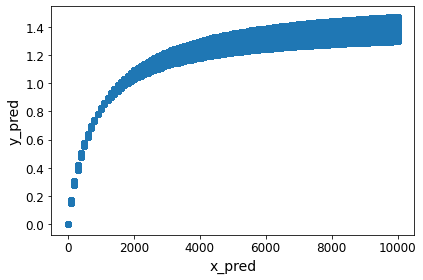

In [15]:
# Create Prediction Set

Prediction_set= pd.DataFrame(data={
                 #Config
                 'Xeq(mg/L)'                : Xeq,
                 'Temperature_(C)'          : Temperature,
                 'pH_Alkalinity'            : pH_Alkalinity, 
                 'Salinity_Monovalent(%wt)' : Salinity_Monovalent, 

                 #Solid
                 'PZC'                      : np.ones(size)*Solid.loc[Solid[Solid['Class'] == Solid_Type].index.values[0], 'PZC'], 
                 'Area(m^2/g)'              : np.ones(size)*Solid.loc[Solid[Solid['Class'] == Solid_Type].index.values[0], 'Area(m^2/g)'], 
                 
                 #Charge
                 'Transitional'             : np.ones(size)*Surfactant.loc[Surfactant[Surfactant['Surfactant'] == Surfactant_Species].index.values[0],'Transitional'], 
                 
                 #Structure
                 'Surf_Length'              : np.ones(size)*Surfactant.loc[Surfactant[Surfactant['Surfactant'] == Surfactant_Species].index.values[0],'Surf_Length'], 
                 'Alkyl_Chain_Length'       : np.ones(size)*Surfactant.loc[Surfactant[Surfactant['Surfactant'] == Surfactant_Species].index.values[0],'Alkyl_Chain_Length'], 
                 'Degree_of_Branching'      : np.ones(size)*Surfactant.loc[Surfactant[Surfactant['Surfactant'] == Surfactant_Species].index.values[0],'Degree_of_Branching'],

                 #Other
                 'MW'                       : np.ones(size)*Surfactant.loc[Surfactant[Surfactant['Surfactant'] == Surfactant_Species].index.values[0],'MW'],

                 #Cosmo
                 'NHB-HB_Donor'             : np.ones(size)*Surfactant.loc[Surfactant[Surfactant['Surfactant'] == Surfactant_Species].index.values[0],'NHB-HB_Donor'],
                 'NHB-Hydrophobicity'       : np.ones(size)*Surfactant.loc[Surfactant[Surfactant['Surfactant'] == Surfactant_Species].index.values[0],'NHB-Hydrophobicity'],
                 'OT-Hydrophobicity'        : np.ones(size)*Surfactant.loc[Surfactant[Surfactant['Surfactant'] == Surfactant_Species].index.values[0],'OT-Hydrophobicity'],
                 'OT-HB_Acceptor'           : np.ones(size)*Surfactant.loc[Surfactant[Surfactant['Surfactant'] == Surfactant_Species].index.values[0],'OT-HB_Acceptor'],
                 'Head_NHB-Hydrophobicity'  : np.ones(size)*Surfactant.loc[Surfactant[Surfactant['Surfactant'] == Surfactant_Species].index.values[0],'Head_NHB-Hydrophobicity'],
                 'Head_NHB-HB_Acceptor'     : np.ones(size)*Surfactant.loc[Surfactant[Surfactant['Surfactant'] == Surfactant_Species].index.values[0],'Head_NHB-HB_Acceptor' ],
                 'Head_OT-HB_Acceptor'      : np.ones(size)*Surfactant.loc[Surfactant[Surfactant['Surfactant'] == Surfactant_Species].index.values[0],'Head_OT-HB_Acceptor'],
                 'Tail_NHB-Hydrophobicity'  : np.ones(size)*Surfactant.loc[Surfactant[Surfactant['Surfactant'] == Surfactant_Species].index.values[0],'Tail_NHB-Hydrophobicity'],
                 'Cavity_Surface_(A**2)'    : np.ones(size)*Surfactant.loc[Surfactant[Surfactant['Surfactant'] == Surfactant_Species].index.values[0],'Cavity_Surface_(A**2)'],
                 
                 
                 # CMC CPP
                 'MolVol'                 : np.ones(size)*Surfactant.loc[Surfactant[Surfactant['Surfactant'] == Surfactant_Species].index.values[0],'MolVol'],
                 'Length (Avogadro, A)'   : np.ones(size)*Surfactant.loc[Surfactant[Surfactant['Surfactant'] == Surfactant_Species].index.values[0],'Length (Avogadro, A)'],
                 'R'                      : np.ones(size)*Surfactant.loc[Surfactant[Surfactant['Surfactant'] == Surfactant_Species].index.values[0],'R'],
                 'Critical Micelle Concentration (M)'   : np.ones(size)*Surfactant.loc[Surfactant[Surfactant['Surfactant'] == Surfactant_Species].index.values[0],'Critical Micelle Concentration (M)']
                
                 
                 
                 })
                 

Pred_Descriptor = list(df.columns.values)
Pred_Descriptor.remove('Sum of Yads(mg/g)')

Prediction_set = Prediction_set [Pred_Descriptor]
X_pred_X = Prediction_set['Xeq(mg/L)'].copy()
X_pred_NonX = Prediction_set[Descriptor_NonX].copy() 

#Prediction
y_pred = model.predict([X_pred_X, X_pred_NonX])

#Plot Prediction 
a = plt.axes()
plt.scatter(X_pred_X, y_pred)
plt.xlabel('x_pred')
plt.ylabel('y_pred')
save_fig('Whole Dataset Evaluate [Isotherm] '+' #' +File_Name)
plt.show()

#plot 3D
grid_results = pd.concat([pd.DataFrame(Prediction_set[Var2]),pd.DataFrame(Prediction_set[Var1]), pd.DataFrame(y_pred, columns=['Predicted Adsorption (mg/g)'])], axis=1)
grid_results.head()

grid_contour = grid_results.groupby([Var2,Var1]).mean()
grid_contour

grid_reset = grid_contour.reset_index()
grid_reset.columns = [Var2, Var1, 'Predicted Adsorption (mg/g)']
grid_pivot = grid_reset.pivot(Var2, Var1)
grid_pivot

x = grid_pivot.columns.levels[1].values
y = grid_pivot.index.values
z = grid_pivot.values

import plotly.graph_objects as go
import plotly.express as px


# X and Y axes labels
layout = go.Layout(
            xaxis=go.layout.XAxis(
              title=go.layout.xaxis.Title(
              text=Var1)
             ),
             yaxis=go.layout.YAxis(
              title=go.layout.yaxis.Title(
              text=Var2) 
            ) )

fig = go.Figure(data = [go.Contour(z=z, x=x, y=y)], layout=layout )

fig.update_layout(title='Prediction Plot', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

#plot 3D
import plotly.graph_objects as go


fig = go.Figure(data= [go.Surface(z=z, y=y, x=x)], layout=layout )
fig.update_layout(title='Prediction Plot',
                  scene = dict(
                    xaxis_title='Equilibrium Concentration (mg/l)',
                    yaxis_title=Var2,
                    zaxis_title='Predicted Adsorption (mg/g)'),
                  autosize=False,
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()



Saving figure Isotherm Test #ANN_COSMO Isotherm No133.png


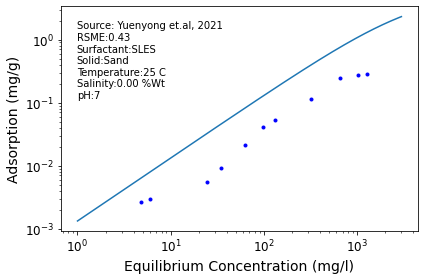

Saving figure Isotherm Test #ANN_COSMO Isotherm No130.png


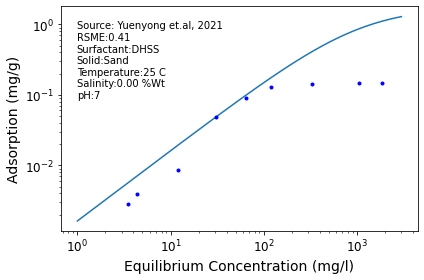

Saving figure Isotherm Test #ANN_COSMO Isotherm No57.png


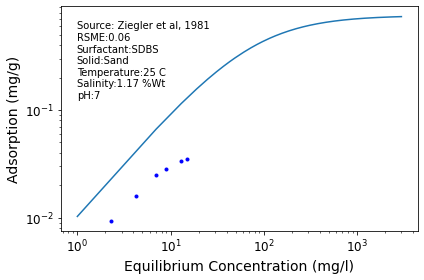

Saving figure Isotherm Test #ANN_COSMO Isotherm No56.png


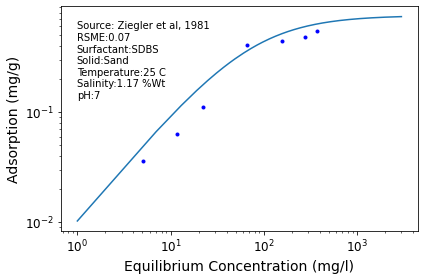

Saving figure Isotherm Test #ANN_COSMO Isotherm No59.png


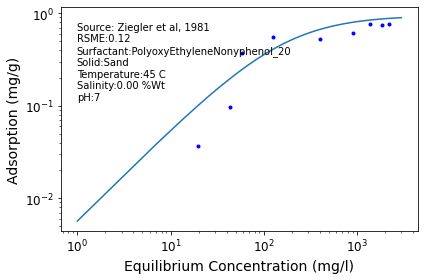

Saving figure Isotherm Test #ANN_COSMO Isotherm No39.png


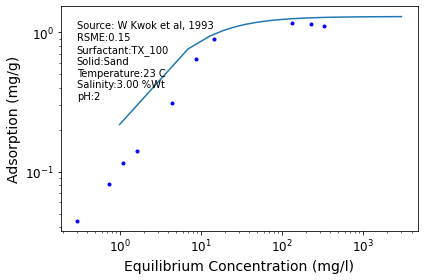

Saving figure Isotherm Test #ANN_COSMO Isotherm No43.png


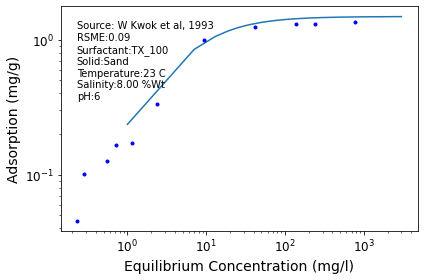

Saving figure Isotherm Test #ANN_COSMO Isotherm No41.png


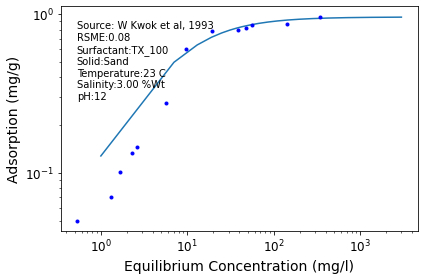

Saving figure Isotherm Test #ANN_COSMO Isotherm No40.png


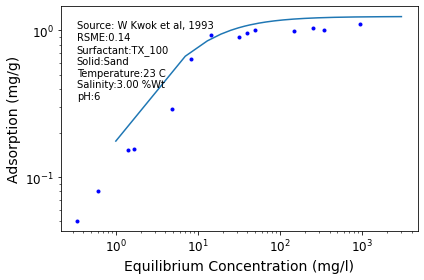

Saving figure Isotherm Test #ANN_COSMO Isotherm No44.png


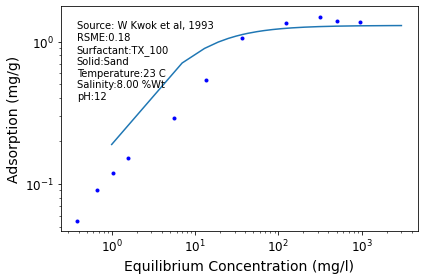

Saving figure Isotherm Test #ANN_COSMO Isotherm No36.png


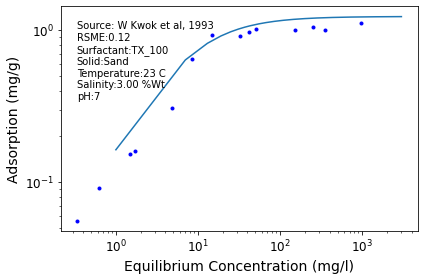

Saving figure Isotherm Test #ANN_COSMO Isotherm No38.png


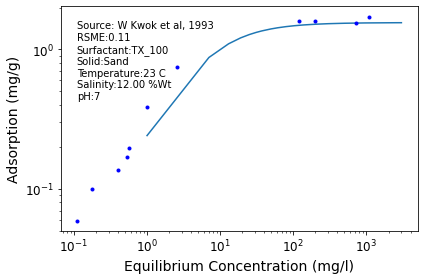

Saving figure Isotherm Test #ANN_COSMO Isotherm No37.png


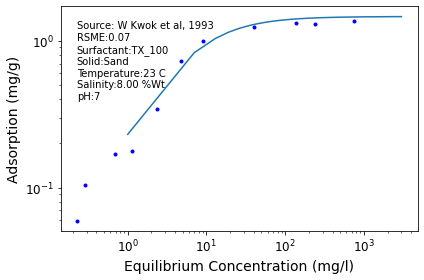

Saving figure Isotherm Test #ANN_COSMO Isotherm No115.png


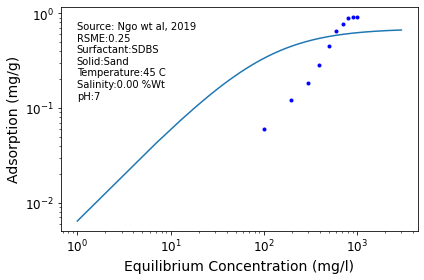

Saving figure Isotherm Test #ANN_COSMO Isotherm No42.png


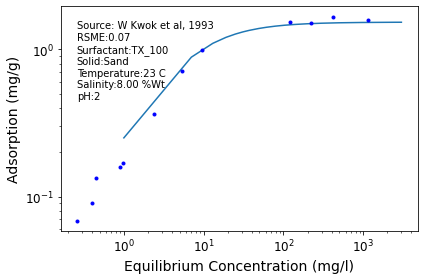

Saving figure Isotherm Test #ANN_COSMO Isotherm No63.png


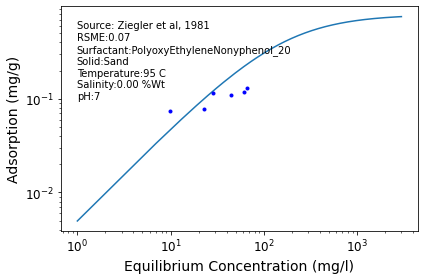

Saving figure Isotherm Test #ANN_COSMO Isotherm No61.png


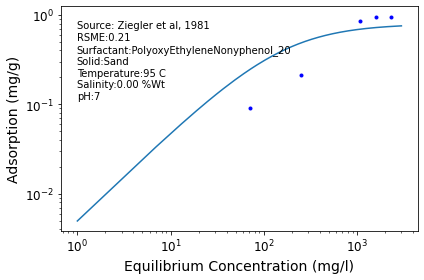

Saving figure Isotherm Test #ANN_COSMO Isotherm No35.png


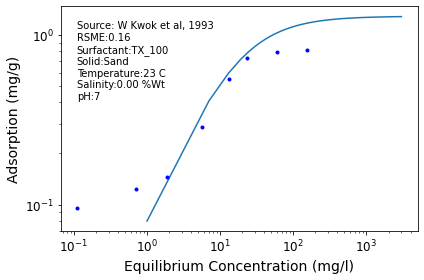

Saving figure Isotherm Test #ANN_COSMO Isotherm No111.png


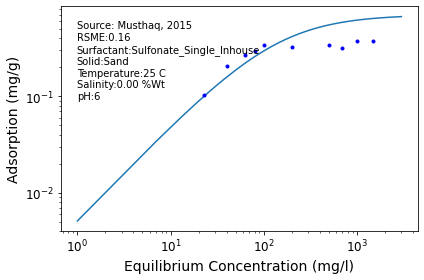

Saving figure Isotherm Test #ANN_COSMO Isotherm No131.png


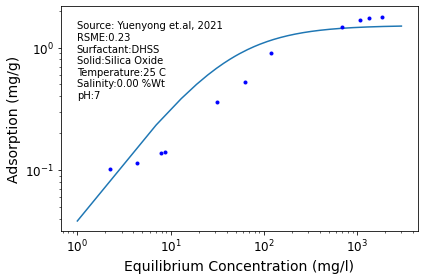

Saving figure Isotherm Test #ANN_COSMO Isotherm No62.png


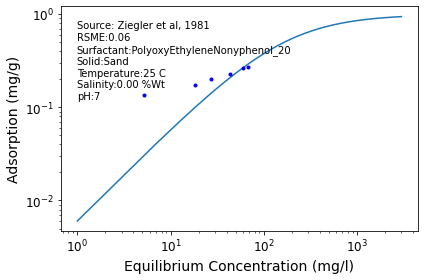

Saving figure Isotherm Test #ANN_COSMO Isotherm No113.png


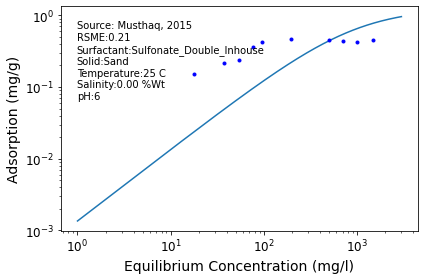

Saving figure Isotherm Test #ANN_COSMO Isotherm No114.png


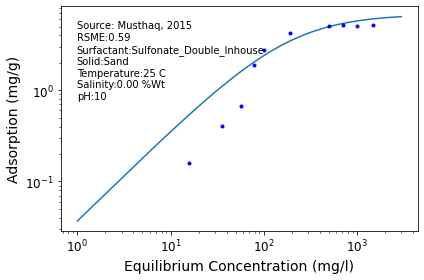

Saving figure Isotherm Test #ANN_COSMO Isotherm No60.png


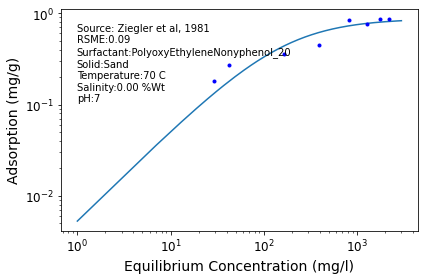

Saving figure Isotherm Test #ANN_COSMO Isotherm No136.png


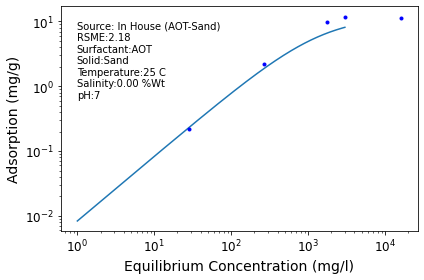

Saving figure Isotherm Test #ANN_COSMO Isotherm No140.png


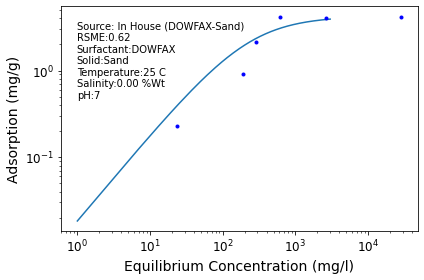

Saving figure Isotherm Test #ANN_COSMO Isotherm No34.png


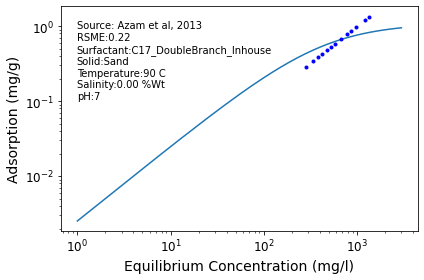

Saving figure Isotherm Test #ANN_COSMO Isotherm No33.png


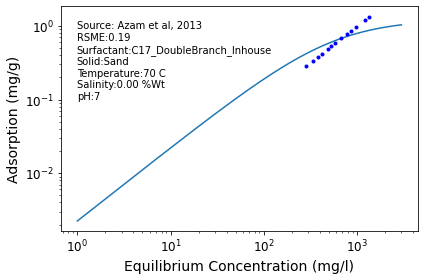

Saving figure Isotherm Test #ANN_COSMO Isotherm No16.png


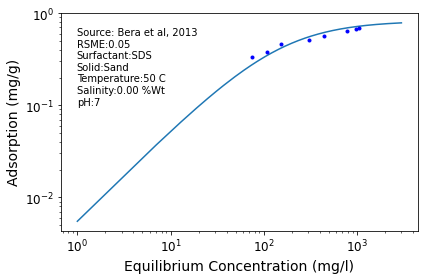

Saving figure Isotherm Test #ANN_COSMO Isotherm No67.png


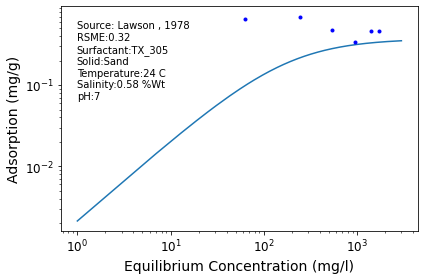

Saving figure Isotherm Test #ANN_COSMO Isotherm No134.png


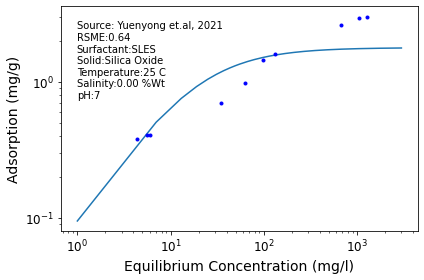

Saving figure Isotherm Test #ANN_COSMO Isotherm No15.png


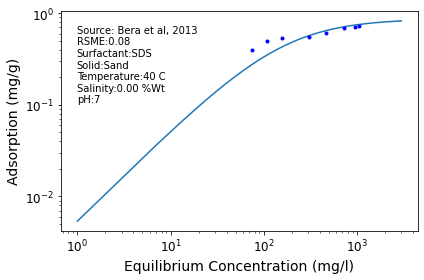

Saving figure Isotherm Test #ANN_COSMO Isotherm No112.png


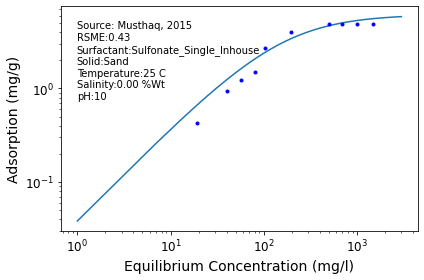

Saving figure Isotherm Test #ANN_COSMO Isotherm No5.png


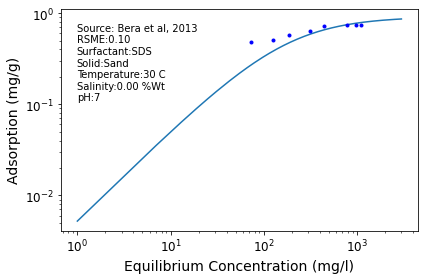

Saving figure Isotherm Test #ANN_COSMO Isotherm No14.png


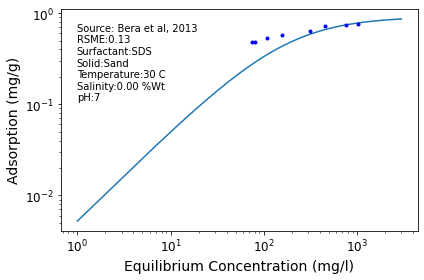

Saving figure Isotherm Test #ANN_COSMO Isotherm No2.png


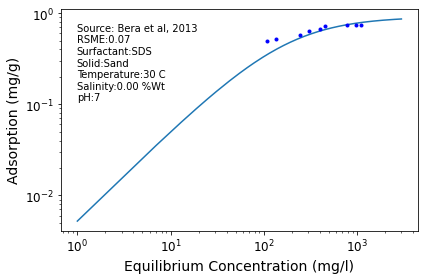

Saving figure Isotherm Test #ANN_COSMO Isotherm No69.png


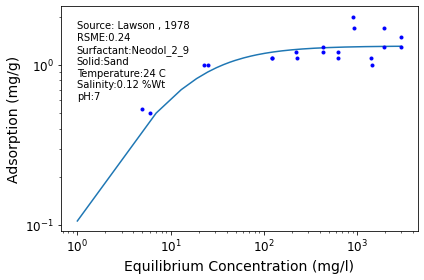

Saving figure Isotherm Test #ANN_COSMO Isotherm No4.png


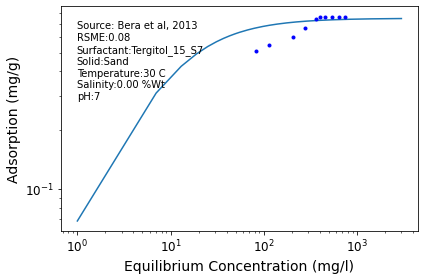

Saving figure Isotherm Test #ANN_COSMO Isotherm No7.png


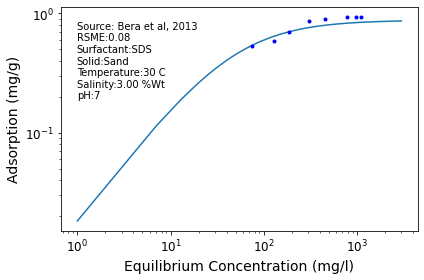

Saving figure Isotherm Test #ANN_COSMO Isotherm No116.png


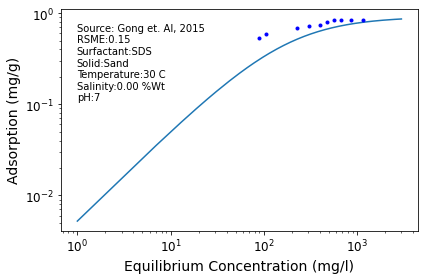

Saving figure Isotherm Test #ANN_COSMO Isotherm No117.png


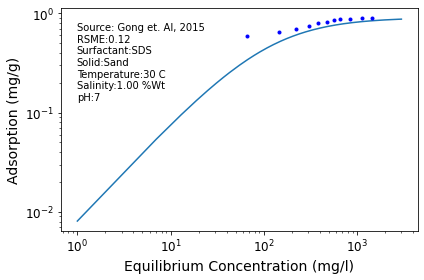

Saving figure Isotherm Test #ANN_COSMO Isotherm No120.png


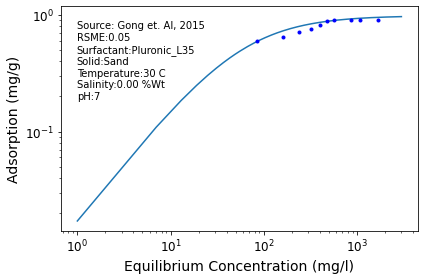

Saving figure Isotherm Test #ANN_COSMO Isotherm No121.png


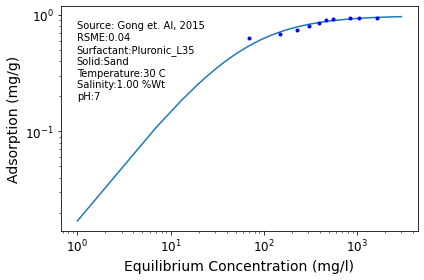

Saving figure Isotherm Test #ANN_COSMO Isotherm No122.png


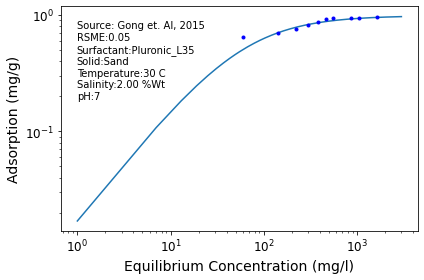

Saving figure Isotherm Test #ANN_COSMO Isotherm No6.png


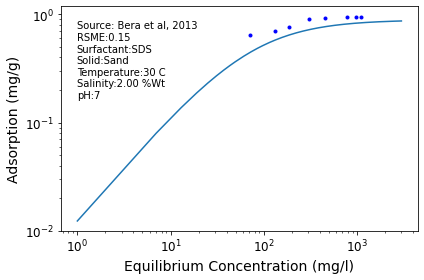

Saving figure Isotherm Test #ANN_COSMO Isotherm No118.png


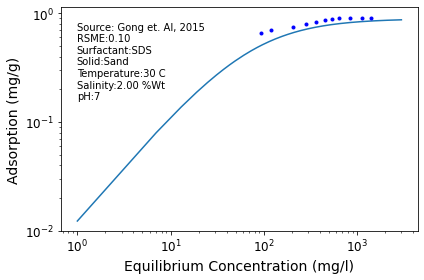

Saving figure Isotherm Test #ANN_COSMO Isotherm No123.png


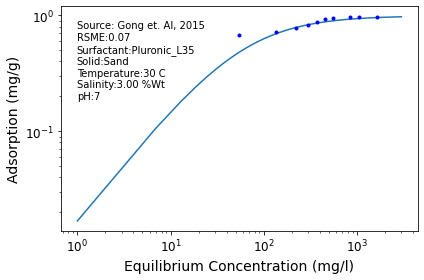

Saving figure Isotherm Test #ANN_COSMO Isotherm No119.png


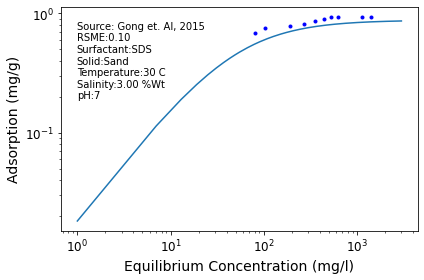

Saving figure Isotherm Test #ANN_COSMO Isotherm No66.png


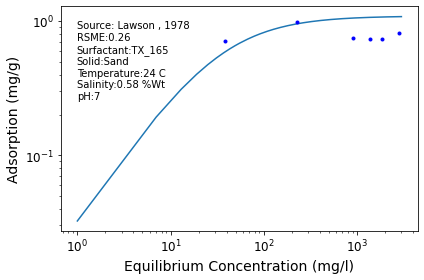

Saving figure Isotherm Test #ANN_COSMO Isotherm No70.png


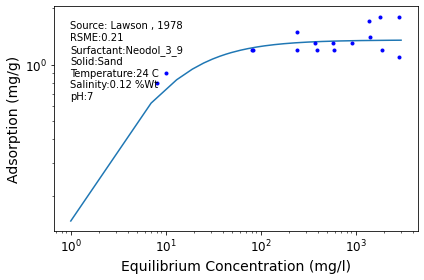

Saving figure Isotherm Test #ANN_COSMO Isotherm No65.png


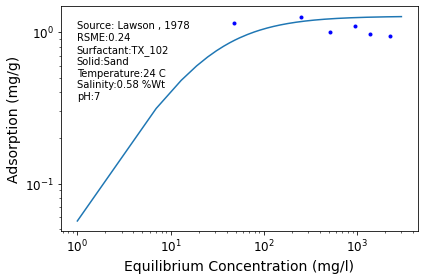

Saving figure Isotherm Test #ANN_COSMO Isotherm No71.png


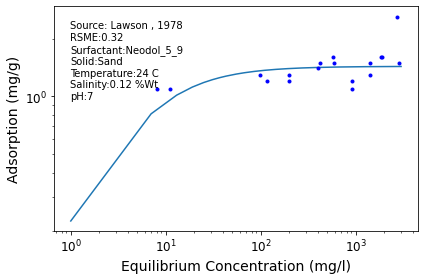

Saving figure Isotherm Test #ANN_COSMO Isotherm No72.png


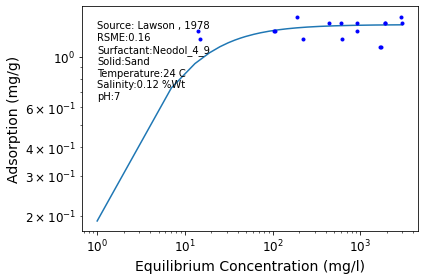

Saving figure Isotherm Test #ANN_COSMO Isotherm No68.png


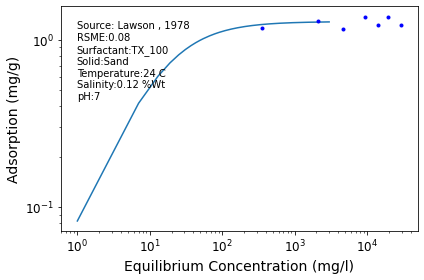

Saving figure Isotherm Test #ANN_COSMO Isotherm No64.png


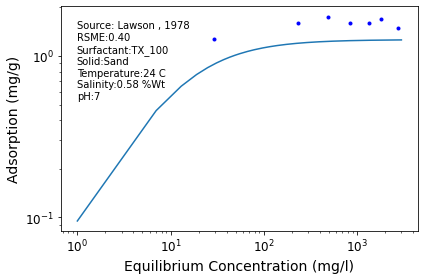

Saving figure Isotherm Test #ANN_COSMO Isotherm No148.png


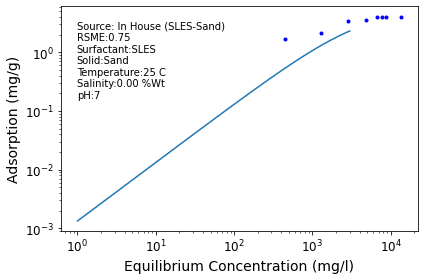

In [19]:
#Evaluate All Dataset
#Load dataset
df_test = pd.read_excel(File_Dataset)

#Empty List
Isotherm_List       = df_test['Isotherm_No'].unique()
#Isotherm_List       = [14]
RMSE_List           = []
R2_List             = []
Surfactant_List     = []
Solid_List          = []
Temperature_List    = []
Salinity_List       = []
pH_List             = []


for isotherm in Isotherm_List:

    Isotherm_No = isotherm
    X_exp = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values, 'Xeq(mg/L)']
    Y_exp = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values, 'Sum of Yads(mg/g)']

    size_isotherm = 100000

    #Config >> Need to be filled for Specific Range
    Xeq                       = np.concatenate([np.linspace(1, 3000, size_isotherm)]) #(mg/l) 

    # Create Prediction Set
    Prediction_set_isotherm= pd.DataFrame(data={
                    #Config
                    'Xeq(mg/L)'                : Xeq,
                    'Temperature_(C)'          : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'Temperature_(C)'],
                    'pH_Alkalinity'            : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'pH_Alkalinity' ], 
                    'Salinity_Monovalent(%wt)' : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'Salinity_Monovalent(%wt)'],

                    #Solid
                    'PZC'                      : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'PZC'], 
                    'Area(m^2/g)'              : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'Area(m^2/g)'], 
                    
                    #Charge
                    'Transitional'             : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Transitional'], 
                    
                    #Structure
                    'Surf_Length'              : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Surf_Length'], 
                    'Alkyl_Chain_Length'       : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Alkyl_Chain_Length'], 
                    'Degree_of_Branching'      : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Degree_of_Branching'],

                    #Other
                    'MW'                       : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'MW'],

                    #Cosmo
                    'NHB-HB_Donor'             : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'NHB-HB_Donor'],
                    'NHB-Hydrophobicity'       : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'NHB-Hydrophobicity'],
                    'OT-Hydrophobicity'        : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'OT-Hydrophobicity'],
                    'OT-HB_Acceptor'           : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'OT-HB_Acceptor'],
                    'Head_NHB-Hydrophobicity'  : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Head_NHB-Hydrophobicity'],
                    'Head_NHB-HB_Acceptor'     : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Head_NHB-HB_Acceptor' ],
                    'Head_OT-HB_Acceptor'      : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Head_OT-HB_Acceptor'],
                    'Tail_NHB-Hydrophobicity'  : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Tail_NHB-Hydrophobicity'],
                    'Cavity_Surface_(A**2)'    : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Cavity_Surface_(A**2)'],



                    # CMC CPP
                    'MolVol'                  : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'MolVol'],
                    'Length (Avogadro, A)'    : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Length (Avogadro, A)'],
                    'R'                       : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'R'],
                    'Critical Micelle Concentration (M)'    : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Critical Micelle Concentration (M)']
                 
                 

                    })
                    

    Pred_Descriptor = list(df.columns.values)
    Pred_Descriptor.remove('Sum of Yads(mg/g)')

    Prediction_set_isotherm = Prediction_set_isotherm [Pred_Descriptor]
    X_pred_X_isotherm = Prediction_set_isotherm['Xeq(mg/L)'].copy()
    X_pred_NonX_isotherm = Prediction_set_isotherm[Descriptor_NonX].copy() 

    #Prediction
    y_pred_isotherm = model.predict([X_pred_X_isotherm, X_pred_NonX_isotherm])

    # Add Error R2 or RMSE
    #RSME
    from sklearn.metrics import mean_squared_error
    pred_isotherm = model.predict([X_exp, X_pred_NonX_isotherm[:X_exp.shape[0]]])
    pred_RSME = np.sqrt(mean_squared_error(Y_exp,pred_isotherm))
    #print('pred RSME:{0}'  .format(pred_RSME))

    #Rsquare
    from sklearn.metrics import r2_score
    pred_Rsquare = r2_score(Y_exp, pred_isotherm)
    #print ('Pred Rsquare:{0}'.format(pred_Rsquare))

    from scipy.interpolate import make_interp_spline
    import matplotlib.pyplot as plt

    X_Y_Spline = make_interp_spline(np.array(X_pred_X_isotherm),np.array(y_pred_isotherm))
    # Returns evenly spaced numbers
    # over a specified interval.
    X_ = np.linspace(X_pred_X_isotherm.min(), X_pred_X_isotherm.max(), 500)
    Y_ = X_Y_Spline(X_)

    #Create Data Frame List

    Note_Surfactant = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Surfactant']
    Note_Author = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Author']
    Note_Solid = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Solid_Class']
    Note_Temperature = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'Temperature_(C)']
    Note_Salinity = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'Salinity_Monovalent(%wt)']
    Note_pH = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'pH_Alkalinity' ]


    RMSE_List.append(pred_RSME)
    R2_List.append(pred_Rsquare)
    Surfactant_List.append(Note_Surfactant)
    Solid_List.append(Note_Solid)      
    Temperature_List.append(Note_Temperature)
    Salinity_List.append(Note_Salinity)   
    pH_List.append(Note_pH)

    # Plotting the Graph
    plt.plot(X_, Y_)
    plt.annotate('Source: ' + str(Note_Author)+
                '\nRSME:{0:1.2f}'.format(pred_RSME)+
                '\nSurfactant:'+ str(Note_Surfactant) + 
                '\nSolid:'+ str(Note_Solid) +
                '\nTemperature:{0:1.0f}'.format(Note_Temperature) +' C'
                '\nSalinity:{0:1.2f}'.format(Note_Salinity) +' %Wt'+
                '\npH:{0:1.0f}'.format(Note_pH),
                xy=(0.01, 0.99), xytext=(12, -12), va='top', xycoords='axes fraction', textcoords='offset points')
    plt.xlabel("Equilibrium Concentration (mg/l)")
    plt.ylabel("Adsorption (mg/g)")
    plt.plot(X_exp, Y_exp, "b.")
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    save_fig('Isotherm Test'+' #' +File_Name + attr + " Isotherm No" + str(Isotherm_No)+'.png')
    plt.show()

    

For_Loop_Result_Isotherm = pd.DataFrame({'Isotherm': Isotherm_List,
                                'RMSE': RMSE_List,
                                'R2': R2_List,
                                'Surfactant': Surfactant_List,
                                'Solid_Class' : Solid_List,
                                'Temperature_(C)' : Temperature_List,
                                'Salinity_Monovalent(%wt)': Salinity_List,
                                'pH_Alkalinity': pH_List})

df_transposed_Isotherm = For_Loop_Result_Isotherm.T
df_transposed_Isotherm
For_Loop_Result_Isotherm.to_csv('Output Isotherm Check'+ ' #'+ File_Name +'.csv')





Saving figure Isotherm Test #ANN_COSMO Isotherm PENP.png


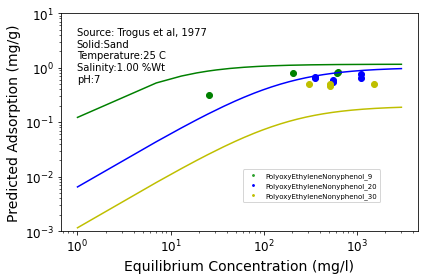

In [59]:
# Predict Molecule

df_test = pd.read_excel('Dataset_CMCCPP_Sand.xlsx')

#Empty List
#Isotherm_List       = df_test['Isotherm_No'].unique()
#Isotherm_List       = [45,46,47,48,49,50,51,52,53,54,55,58,84,85,86,87,88,107,144]
Isotherm_List       = {45:'g',46:'b', 47:'y'}
RMSE_List           = []
R2_List             = []
Surfactant_List     = []
Solid_List          = []
Temperature_List    = []
Salinity_List       = []
pH_List             = []


for isotherm in Isotherm_List:

    Isotherm_No = isotherm
    X_exp = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values, 'Xeq(mg/L)']
    Y_exp = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values, 'Sum of Yads(mg/g)']

    size_isotherm = 100000

    #Config >> Need to be filled for Specific Range
    Xeq                       = np.concatenate([np.linspace(1, 3000, size_isotherm)]) #(mg/l) 

    # Create Prediction Set
    Prediction_set_isotherm= pd.DataFrame(data={
                    #Config
                    'Xeq(mg/L)'                : Xeq,
                    'Temperature_(C)'          : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'Temperature_(C)'],
                    'pH_Alkalinity'            : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'pH_Alkalinity' ], 
                    'Salinity_Monovalent(%wt)' : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'Salinity_Monovalent(%wt)'],

                    #Solid
                    'PZC'                      : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'PZC'], 
                    'Area(m^2/g)'              : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'Area(m^2/g)'], 
                    
                    #Charge
                    'Transitional'             : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Transitional'], 
                    
                    #Structure
                    'Surf_Length'              : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Surf_Length'], 
                    'Alkyl_Chain_Length'       : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Alkyl_Chain_Length'], 
                    'Degree_of_Branching'      : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Degree_of_Branching'],

                    #Other
                    'MW'                       : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'MW'],

                    #Cosmo
                    'NHB-HB_Donor'             : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'NHB-HB_Donor'],
                    'NHB-Hydrophobicity'       : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'NHB-Hydrophobicity'],
                    'OT-Hydrophobicity'        : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'OT-Hydrophobicity'],
                    'OT-HB_Acceptor'           : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'OT-HB_Acceptor'],
                    'Head_NHB-Hydrophobicity'  : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Head_NHB-Hydrophobicity'],
                    'Head_NHB-HB_Acceptor'     : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Head_NHB-HB_Acceptor' ],
                    'Head_OT-HB_Acceptor'      : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Head_OT-HB_Acceptor'],
                    'Tail_NHB-Hydrophobicity'  : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Tail_NHB-Hydrophobicity'],
                    'Cavity_Surface_(A**2)'    : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Cavity_Surface_(A**2)'],



                    # CMC CPP
                    'MolVol'                  : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'MolVol'],
                    'Length (Avogadro, A)'    : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Length (Avogadro, A)'],
                    'R'                       : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'R'],
                    'Critical Micelle Concentration (M)'    : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Critical Micelle Concentration (M)']
                 
                 

                    })
                    

    Pred_Descriptor = list(df.columns.values)
    Pred_Descriptor.remove('Sum of Yads(mg/g)')

    Prediction_set_isotherm = Prediction_set_isotherm [Pred_Descriptor]
    X_pred_X_isotherm = Prediction_set_isotherm['Xeq(mg/L)'].copy()
    X_pred_NonX_isotherm = Prediction_set_isotherm[Descriptor_NonX].copy() 

    #Prediction
    y_pred_isotherm = model.predict([X_pred_X_isotherm, X_pred_NonX_isotherm])

    # Add Error R2 or RMSE
    #RSME
    from sklearn.metrics import mean_squared_error
    pred_isotherm = model.predict([X_exp, X_pred_NonX_isotherm[:X_exp.shape[0]]])
    pred_RSME = np.sqrt(mean_squared_error(Y_exp,pred_isotherm))
    #print('pred RSME:{0}'  .format(pred_RSME))

    #Rsquare
    from sklearn.metrics import r2_score
    pred_Rsquare = r2_score(Y_exp, pred_isotherm)
    #print ('Pred Rsquare:{0}'.format(pred_Rsquare))

    from scipy.interpolate import make_interp_spline
    import matplotlib.pyplot as plt

    X_Y_Spline = make_interp_spline(np.array(X_pred_X_isotherm),np.array(y_pred_isotherm))
    # Returns evenly spaced numbers
    # over a specified interval.
    X_ = np.linspace(X_pred_X_isotherm.min(), X_pred_X_isotherm.max(), 500)
    Y_ = X_Y_Spline(X_)

    #Create Data Frame List

    Note_Surfactant = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Surfactant']
    Note_Author = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Author']
    Note_Solid = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Solid_Class']
    Note_Temperature = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'Temperature_(C)']
    Note_Salinity = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'Salinity_Monovalent(%wt)']
    Note_pH = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'pH_Alkalinity' ]


    RMSE_List.append(pred_RSME)
    R2_List.append(pred_Rsquare)
    Surfactant_List.append(Note_Surfactant)
    Solid_List.append(Note_Solid)      
    Temperature_List.append(Note_Temperature)
    Salinity_List.append(Note_Salinity)   
    pH_List.append(Note_pH)

    # Plotting the Graph
    plt.plot(X_, Y_, color=Isotherm_List[isotherm])

    plt.xlabel("Equilibrium Concentration (mg/l)")
    plt.ylabel("Predicted Adsorption (mg/g)")
    plt.scatter(X_exp, Y_exp, color=Isotherm_List[isotherm])
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([0.001,10])
    plt.tight_layout()

plt.annotate('Source: ' + str(Note_Author)+
             '\nSolid:'+ str(Note_Solid) +
             '\nTemperature:{0:1.0f}'.format(Note_Temperature) +' C'
             '\nSalinity:{0:1.2f}'.format(Note_Salinity) +' %Wt'+
             '\npH:{0:1.0f}'.format(Note_pH),
             xy=(0.01, 0.99), xytext=(12, -12), va='top', xycoords='axes fraction', textcoords='offset points')


Surfactant_List_Pred = {'PolyoxyEthyleneNonyphenol_9':'tab:green' , 'PolyoxyEthyleneNonyphenol_20':'b','PolyoxyEthyleneNonyphenol_30':'y' }
markers1 = [plt.Line2D([0.1,0.1],[0.1,0.1],color=color, marker='o', linestyle='') for color in Surfactant_List_Pred.values()]
legend1 = plt.legend(markers1, Surfactant_List_Pred.keys(), numpoints=1, loc='upper left', bbox_to_anchor=(0.5, 0.3), fontsize=7, markerscale=0.3)  

save_fig('Isotherm Test'+' #' +File_Name + attr + " Isotherm PENP.png")
plt.show()


In [60]:
# Predict Molecule

df_test = pd.read_excel('Dataset_CMCCPP_Sand.xlsx')

#Empty List
#Isotherm_List       = df_test['Isotherm_No'].unique()
#Isotherm_List       = [45,46,47,48,49,50,51,52,53,54,55,58,84,85,86,87,88,107,144]
Isotherm_List       = {144:'g'}
RMSE_List           = []
R2_List             = []
Surfactant_List     = []
Solid_List          = []
Temperature_List    = []
Salinity_List       = []
pH_List             = []


for isotherm in Isotherm_List:

    Isotherm_No = isotherm
    X_exp = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values, 'Xeq(mg/L)']
    Y_exp = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values, 'Sum of Yads(mg/g)']

    size_isotherm = 100000

    #Config >> Need to be filled for Specific Range
    Xeq                       = np.concatenate([np.linspace(1, 3000, size_isotherm)]) #(mg/l) 

    # Create Prediction Set
    Prediction_set_isotherm= pd.DataFrame(data={
                    #Config
                    'Xeq(mg/L)'                : Xeq,
                    'Temperature_(C)'          : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'Temperature_(C)'],
                    'pH_Alkalinity'            : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'pH_Alkalinity' ], 
                    'Salinity_Monovalent(%wt)' : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'Salinity_Monovalent(%wt)'],

                    #Solid
                    'PZC'                      : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'PZC'], 
                    'Area(m^2/g)'              : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'Area(m^2/g)'], 
                    
                    #Charge
                    'Transitional'             : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Transitional'], 
                    
                    #Structure
                    'Surf_Length'              : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Surf_Length'], 
                    'Alkyl_Chain_Length'       : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Alkyl_Chain_Length'], 
                    'Degree_of_Branching'      : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Degree_of_Branching'],

                    #Other
                    'MW'                       : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'MW'],

                    #Cosmo
                    'NHB-HB_Donor'             : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'NHB-HB_Donor'],
                    'NHB-Hydrophobicity'       : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'NHB-Hydrophobicity'],
                    'OT-Hydrophobicity'        : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'OT-Hydrophobicity'],
                    'OT-HB_Acceptor'           : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'OT-HB_Acceptor'],
                    'Head_NHB-Hydrophobicity'  : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Head_NHB-Hydrophobicity'],
                    'Head_NHB-HB_Acceptor'     : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Head_NHB-HB_Acceptor' ],
                    'Head_OT-HB_Acceptor'      : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Head_OT-HB_Acceptor'],
                    'Tail_NHB-Hydrophobicity'  : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Tail_NHB-Hydrophobicity'],
                    'Cavity_Surface_(A**2)'    : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Cavity_Surface_(A**2)'],



                    # CMC CPP
                    'MolVol'                  : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'MolVol'],
                    'Length (Avogadro, A)'    : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Length (Avogadro, A)'],
                    'R'                       : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'R'],
                    'Critical Micelle Concentration (M)'    : np.ones(size_isotherm)*df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Critical Micelle Concentration (M)']
                 
                 

                    })
                    

    Pred_Descriptor = list(df.columns.values)
    Pred_Descriptor.remove('Sum of Yads(mg/g)')

    Prediction_set_isotherm = Prediction_set_isotherm [Pred_Descriptor]
    X_pred_X_isotherm = Prediction_set_isotherm['Xeq(mg/L)'].copy()
    X_pred_NonX_isotherm = Prediction_set_isotherm[Descriptor_NonX].copy() 

    #Prediction
    y_pred_isotherm = model.predict([X_pred_X_isotherm, X_pred_NonX_isotherm])

    # Add Error R2 or RMSE
    #RSME
    from sklearn.metrics import mean_squared_error
    pred_isotherm = model.predict([X_exp, X_pred_NonX_isotherm[:X_exp.shape[0]]])
    pred_RSME = np.sqrt(mean_squared_error(Y_exp,pred_isotherm))
    #print('pred RSME:{0}'  .format(pred_RSME))

    #Rsquare
    from sklearn.metrics import r2_score
    pred_Rsquare = r2_score(Y_exp, pred_isotherm)
    #print ('Pred Rsquare:{0}'.format(pred_Rsquare))

    from scipy.interpolate import make_interp_spline
    import matplotlib.pyplot as plt

    X_Y_Spline = make_interp_spline(np.array(X_pred_X_isotherm),np.array(y_pred_isotherm))
    # Returns evenly spaced numbers
    # over a specified interval.
    X_ = np.linspace(X_pred_X_isotherm.min(), X_pred_X_isotherm.max(), 500)
    Y_ = X_Y_Spline(X_)

    #Create Data Frame List

    Note_Surfactant = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Surfactant']
    Note_Author = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Author']
    Note_Solid = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0],'Solid_Class']
    Note_Temperature = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'Temperature_(C)']
    Note_Salinity = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'Salinity_Monovalent(%wt)']
    Note_pH = df_test.loc[df_test[df_test['Isotherm_No'] == Isotherm_No].index.values[0], 'pH_Alkalinity' ]


    RMSE_List.append(pred_RSME)
    R2_List.append(pred_Rsquare)
    Surfactant_List.append(Note_Surfactant)
    Solid_List.append(Note_Solid)      
    Temperature_List.append(Note_Temperature)
    Salinity_List.append(Note_Salinity)   
    pH_List.append(Note_pH)

    # Plotting the Graph
    plt.plot(X_, Y_, color=Isotherm_List[isotherm])

    plt.xlabel("Equilibrium Concentration (mg/l)")
    plt.ylabel("Predicted Adsorption (mg/g)")
    plt.scatter(X_exp, Y_exp, color=Isotherm_List[isotherm])
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([0.01,10])
    plt.tight_layout()

plt.annotate('Source: ' + str(Note_Author)+
             '\nSolid:'+ str(Note_Solid) +
             '\nTemperature:{0:1.0f}'.format(Note_Temperature) +' C'
             '\nSalinity:{0:1.2f}'.format(Note_Salinity) +' %Wt'+
             '\npH:{0:1.0f}'.format(Note_pH),
             xy=(0.01, 0.99), xytext=(12, -12), va='top', xycoords='axes fraction', textcoords='offset points')


Surfactant_List_Pred = {'IOS':'tab:green' }
markers1 = [plt.Line2D([0.1,0.1],[0.1,0.1],color=color, marker='o', linestyle='') for color in Surfactant_List_Pred.values()]
legend1 = plt.legend(markers1, Surfactant_List_Pred.keys(), numpoints=1, loc='upper left', bbox_to_anchor=(0.5, 0.3), fontsize=7, markerscale=0.3)  

save_fig('Isotherm Test'+' #' +File_Name + attr + " Isotherm Pred IOS.png')
plt.show()


SyntaxError: EOL while scanning string literal (Temp/ipykernel_15656/2805424578.py, line 148)